In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#If neccesary
class OneHotEncoder:
    def __init__(self):
        self.categories = None

    def fit(self, y):
        self.categories = np.unique(y)

    def transform(self, y):
        return np.array([self.categories == val for val in y]).astype(int)

    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

# Activation Funcion and Loss Function

In [3]:
#Loss function : Cross Entropy
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = Softmax(X) 
        return -np.log(self.p[range(self.m), y])[0] / self.m
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = Softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

#Activation function : ReLU
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []
    
    
#Activation function : Softmax
def Softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    out= exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return out

# Mini Batch

In [4]:
#Minibatch
def batch(X, y, batch_size):
    shuffle = X.shape[0]
    
    #randomization
    shuffled_idx = np.random.permutation(shuffle)
    X = X[shuffled_idx]
    y = y[shuffled_idx]

    batches = [(X[i:i+batch_size,:], y[i:i+batch_size,])
                   for i in range(0, shuffle, batch_size)]
    
    return batches

# Optimization Function

In [5]:
#Optimization
def momentum_optimizer(velocity, params, grads, alpha=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            p[i] -= mu * v[i] + alpha * g[i]

In [6]:
#Change learning rate
def step_decay_scheduler(initial_lr, decay_factor, step_size, current_epoch):
    if initial_lr <=0.0001:
        return initial_lr
    
    if current_epoch % step_size == 0 and current_epoch>=step_size:
        return initial_lr * decay_factor
    else:
        return initial_lr

# Neural Network

In [7]:
#Linear feedforward and backpropaction
class Dense():
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
        self.params = [self.W, self.b]
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [np.dot(self.X.T, nextgrad), np.sum(nextgrad, axis=0)]

In [8]:
class NeuralNetwork():
    def __init__(self, lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.grads=[]
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def propagation(self, X, y):
        output = self.forward(X)
        loss = self.loss_func.forward(output,y)
        l2 = self.backward(self.loss_func.backward(output,y))
        return loss, l2
    
    def predict(self, X):
        scores = self.forward(X)
        return np.argmax(scores, axis=1), scores


In [9]:
def train(net, X_train, y_train, X_val, y_val, batch_size, epoch, alpha, mu=0.9):
    history_train_loss = []
    history_val_loss = []
    history_train_acc = []
    history_val_acc = []
    
    for e in range(epoch):
        #transform learning rate along epoch
        alpha = step_decay_scheduler(alpha, 0.05, 20, e)
        
        #Make mini batch set
        train_batches = batch(X_train, y_train, batch_size)
        val_batches = batch(X_val, y_val, batch_size)
        
        #Veolocity for optimization
        velocity=[]
        for params in net.params:
            velocity.append([np.zeros_like(param) for param in list(params)])   
            
        # Train non-validation set and calculate loss
        train_losses = []
        for X_batch_train, y_batch_train in train_batches:
            train_loss, grads = net.propagation(X_batch_train, y_batch_train)
            train_losses.append(train_loss)
            momentum_optimizer(velocity, net.params, grads, alpha=alpha, mu=mu)
        
        # Calculate non-validation loss
        val_losses = []
        for X_batch_val, y_batch_val in val_batches:
            val_loss, _ = net.propagation(X_batch_val, y_batch_val)
            val_losses.append(val_loss)
        
        # Recording loss
        mean_train_loss = sum(train_losses) / float(len(train_losses))
        mean_val_loss = sum(val_losses) / float(len(val_losses))
        
        history_train_loss.append(mean_train_loss)
        history_val_loss.append(mean_val_loss)
        
        # Calculate accuracy for training, validation, and test sets
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_batch_train = []
        y_batch_val = []
        
        #Calculate accuracy
        for X_batch, y_batch in train_batches:
            y_batch_train = np.append(y_batch_train, y_batch)
            y_train_pred = np.append(y_train_pred, net.predict(X_batch)[0])
    
        for X_batch, y_batch in val_batches:
            y_batch_val = np.append(y_batch_val, y_batch)
            y_val_pred = np.append(y_val_pred, net.predict(X_batch)[0])
            
        #Recording accuarcy
        train_acc = accuracy(y_batch_train, y_train_pred)
        val_acc = accuracy(y_batch_val, y_val_pred)
        history_train_acc.append(train_acc)
        history_val_acc.append(val_acc) 
        
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
      
    
    #Visualize Loss
    visualize_loss(history_train_loss, history_val_loss)
    visualize_accuracy(epoch, history_train_acc, history_val_acc)

    return net

# Expression function

In [10]:
def accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

def visualize_loss(history_train_loss, history_val_loss):
    plt.plot(range(1, epoch+1), history_train_loss, c='blue', label='Training Loss')
    plt.plot(range(1, epoch+1), history_val_loss, c='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()    
           
def visualize_accuracy(epoch, history_train_acc, history_val_acc):
    plt.plot(range(1, epoch+1), history_train_acc, c='blue', label='Train Acc')
    plt.plot(range(1, epoch+1), history_val_acc, c='red', label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()        

# Real Data1

In [11]:
#Read Data
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

#train set
X_train = train_data.iloc[:, 1:].values/255.0
y_train = train_data.iloc[:, 0].values

#test set
X_test = test_data.iloc[:, 1:].values/255.0
y_test = test_data.iloc[:, 0].values

#validation set rate
train_idx = np.random.choice(range(len(X_train)), int(len(X_train) * 0.95), replace=False)
val_idx = list(set(range(len(X_train))) - set(train_idx))

#order: validation set, non-validation set
X_val, y_val  = X_train[val_idx],y_train[val_idx]
X_train, y_train= X_train[train_idx], y_train[train_idx]

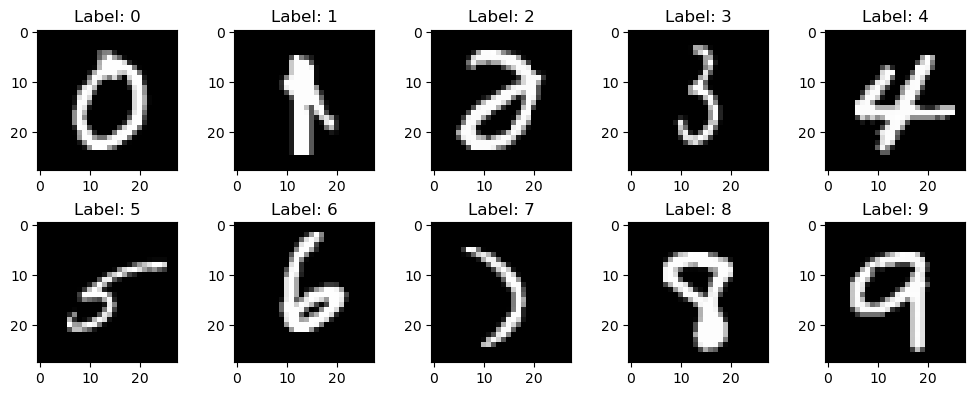

In [12]:
#Visualization
labels = list(range(10))

# Show images for each label
fig, axes = plt.subplots(2, 5, figsize=(10,4))

for label, ax in zip(labels, axes.flat):
    indices = np.where(y_train == label)[0]
    image = X_train[indices[0]].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()


Loss = 0.022907388236410406 | Training Accuracy = 0.30912823031983017 | Val Loss = 0.02032829889376285 | Val Accuracy = 0.298
Loss = 0.009253785922470663 | Training Accuracy = 0.8632607589606835 | Val Loss = 0.005178376450083405 | Val Accuracy = 0.86
Loss = 0.0038457119371285487 | Training Accuracy = 0.9089282268109967 | Val Loss = 0.0019955418990118966 | Val Accuracy = 0.8986666666666666
Loss = 0.0024049246123347173 | Training Accuracy = 0.9332444428849629 | Val Loss = 0.004339047788034995 | Val Accuracy = 0.926
Loss = 0.0020158860810338963 | Training Accuracy = 0.9439288408568571 | Val Loss = 0.002365760739305937 | Val Accuracy = 0.934
Loss = 0.0016080772577102653 | Training Accuracy = 0.9540167371357392 | Val Loss = 0.0006468435081294105 | Val Accuracy = 0.9473333333333334
Loss = 0.0011983098562158804 | Training Accuracy = 0.9587185740100703 | Val Loss = 0.00046093277545114 | Val Accuracy = 0.9493333333333334
Loss = 0.0020261334920639324 | Training Accuracy = 0.9630344392006878 | Va

Loss = 0.0003548976657084756 | Training Accuracy = 0.9883506728188214 | Val Loss = 0.004538519511256676 | Val Accuracy = 0.9693333333333334
Loss = 0.00039042699951038573 | Training Accuracy = 0.9883331286513799 | Val Loss = 0.002525870686754412 | Val Accuracy = 0.9693333333333334
Loss = 0.0004321176391114846 | Training Accuracy = 0.9883331286513799 | Val Loss = 0.000809857905579927 | Val Accuracy = 0.9693333333333334
Loss = 0.0005202001316409375 | Training Accuracy = 0.9883331286513799 | Val Loss = 0.0007140273522188872 | Val Accuracy = 0.9693333333333334
Loss = 0.0003832871061862521 | Training Accuracy = 0.9883331286513799 | Val Loss = 0.0006356961532160076 | Val Accuracy = 0.9693333333333334
Loss = 0.000355769839684829 | Training Accuracy = 0.9883331286513799 | Val Loss = 0.0005739879610456915 | Val Accuracy = 0.9693333333333334
Loss = 0.0005333373674524227 | Training Accuracy = 0.9883331286513799 | Val Loss = 0.0012986721923717653 | Val Accuracy = 0.9693333333333334
Loss = 0.0007140

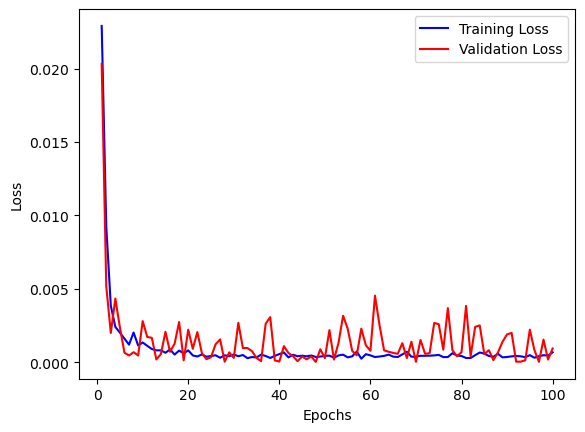

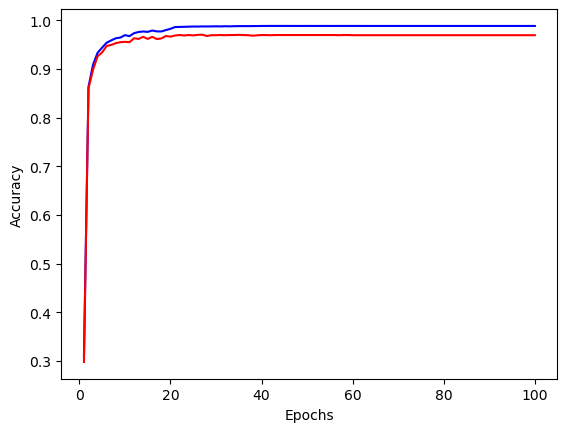

In [13]:
## input size
in_nodes = X_train.shape[1]

## hyperparameters
epoch = 100
alpha = 0.1
h_nodes1 = 32
h_nodes2 = 32
out_nodes = 10


## define neural net
nn = NeuralNetwork()
nn.add_layer(Dense(in_nodes, h_nodes1))
nn.add_layer(ReLU())
nn.add_layer(Dense(h_nodes1, h_nodes2))
nn.add_layer(ReLU())
nn.add_layer(Dense(h_nodes2, out_nodes))

train(nn, X_train, y_train, X_val, y_val,
           batch_size=100, epoch=epoch, alpha=alpha)


In [14]:
test_acc = np.mean([nn.predict(X_test[i])[0]==y_test[i] for i in range(len(X_test))])   
print("\nTest Accurarcy = {0}".format(test_acc))   


Test Accurarcy = 0.9702970297029703


# Real Data2

In [15]:
# Read Data
train_data = pd.read_csv('mnist_traindata.csv')
test_data = pd.read_csv('mnist_evaldata.csv')

# train set
X_train = train_data.iloc[:, 1:].values / 255.0
y_train = train_data.iloc[:, 0].values

# test set
X_test = test_data.iloc[:, 1:].values / 255.0
y_test = test_data.iloc[:, 0].values

# validation set rate
train_idx = np.random.choice(range(len(X_train)), int(len(X_train) * 0.95), replace=False)
val_idx = list(set(range(len(X_train))) - set(train_idx))

# order: validation set, non-validation set
X_val, y_val = X_train[val_idx], y_train[val_idx]
X_train, y_train = X_train[train_idx], y_train[train_idx]


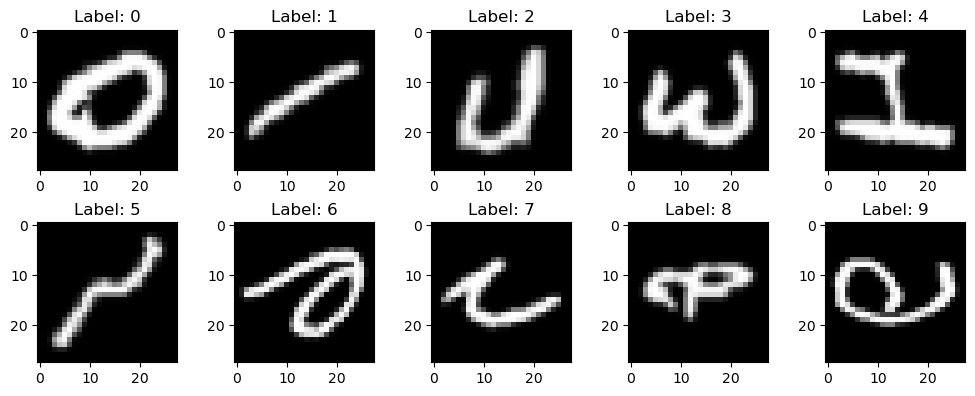

In [16]:
#Visualization
labels = list(range(10))

# Show images for each label
fig, axes = plt.subplots(2, 5, figsize=(10,4))

for label, ax in zip(labels, axes.flat):
    indices = np.where(y_train == label)[0]
    image = X_train[indices[0]].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()


Loss = 0.020179404401204148 | Training Accuracy = 0.6526956613273918 | Val Loss = 0.00873466470505465 | Val Accuracy = 0.6633333333333333
Loss = 0.006151735136598236 | Training Accuracy = 0.88357690485798 | Val Loss = 0.006643336979350141 | Val Accuracy = 0.8933333333333333
Loss = 0.0024435281535268726 | Training Accuracy = 0.9348058737872594 | Val Loss = 0.0015129925135036132 | Val Accuracy = 0.934
Loss = 0.002186767832960714 | Training Accuracy = 0.9474201301777224 | Val Loss = 0.0012357180679012309 | Val Accuracy = 0.9466666666666667
Loss = 0.0019677217019878233 | Training Accuracy = 0.9504903594799908 | Val Loss = 0.001205513591341355 | Val Accuracy = 0.944
Loss = 0.0013618703250036974 | Training Accuracy = 0.9672274952192144 | Val Loss = 0.0010921686531495237 | Val Accuracy = 0.9623333333333334
Loss = 0.0014111860848410043 | Training Accuracy = 0.9631397042053369 | Val Loss = 0.002689462417485295 | Val Accuracy = 0.9586666666666667
Loss = 0.0015231284198240851 | Training Accuracy 

Loss = 0.00046159571527048556 | Training Accuracy = 0.9908419445955192 | Val Loss = 0.000412607072887434 | Val Accuracy = 0.9753333333333334
Loss = 0.0003099390748089971 | Training Accuracy = 0.9908419445955192 | Val Loss = 6.120277196137804e-05 | Val Accuracy = 0.9753333333333334
Loss = 0.00023991011314588326 | Training Accuracy = 0.9908419445955192 | Val Loss = 0.0025566002777798248 | Val Accuracy = 0.9753333333333334
Loss = 0.0004536454290084203 | Training Accuracy = 0.9908419445955192 | Val Loss = 2.5295909503027823e-05 | Val Accuracy = 0.9753333333333334
Loss = 0.00029471238660475855 | Training Accuracy = 0.9908419445955192 | Val Loss = 0.0015960563638448293 | Val Accuracy = 0.9753333333333334
Loss = 0.0004197230735307897 | Training Accuracy = 0.9908419445955192 | Val Loss = 0.0003659226565344978 | Val Accuracy = 0.9753333333333334
Loss = 0.0004565574168053127 | Training Accuracy = 0.9908419445955192 | Val Loss = 0.00014014437573310685 | Val Accuracy = 0.9753333333333334
Loss = 0.

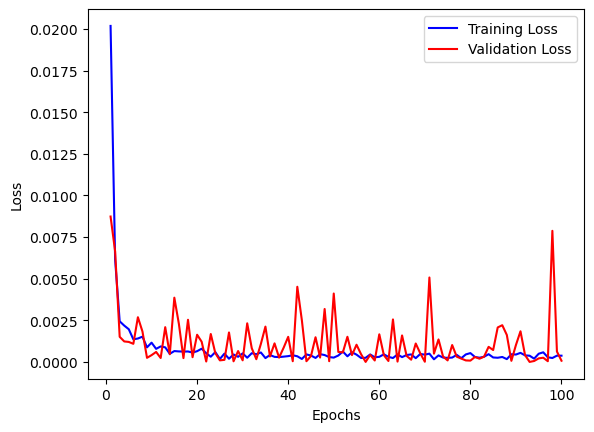

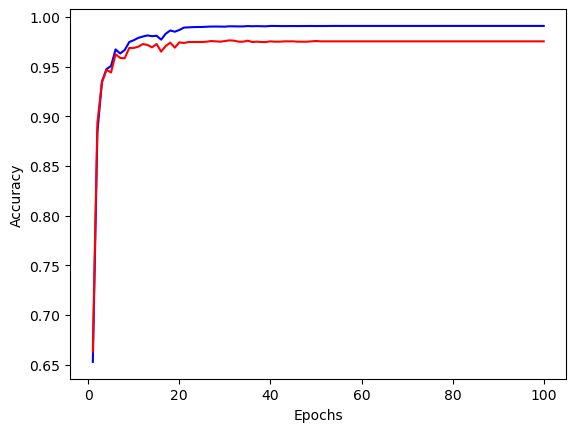

In [17]:
## input size
in_nodes = X_train.shape[1]

## hyperparameters
epoch = 100
alpha = 0.1
h_nodes1 = 32
h_nodes2 = 32
out_nodes = 10

## define neural net
nn2 = NeuralNetwork()
nn2.add_layer(Dense(in_nodes, h_nodes1))
nn2.add_layer(ReLU())
nn2.add_layer(Dense(h_nodes1, h_nodes2))
nn2.add_layer(ReLU())
nn2.add_layer(Dense(h_nodes2, out_nodes))

train(nn2, X_train, y_train, X_val, y_val,
           batch_size=100, epoch=epoch, alpha=alpha)


In [18]:
test_acc = np.mean([nn2.predict(X_test[i])[0]==y_test[i] for i in range(len(X_test))])   
print("\nTest Accurarcy = {0}".format(test_acc))   


Test Accurarcy = 0.9775244381109528
